In [1]:
import numpy as np
import pylab as plt

In [2]:
# from tensorflow.keras.datasets.mnist import load_data
# # load the images into memory
# (trainX, trainy), (testX, testy) = load_data()
# # summarize the shape of the dataset
# print('Train', trainX.shape, trainy.shape)
# print('Test', testX.shape, testy.shape)

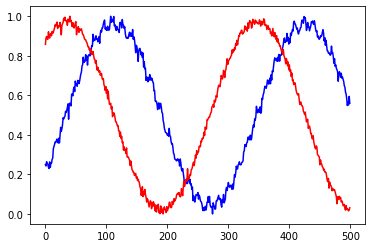

In [38]:
def generate_samples(n_sample,nf = 500,noise=0.03,real=True):
    ys = []
    for _ in range(n_sample):
        x = np.linspace(0,10,nf)
        a = np.random.uniform(0.9,1.1)
        b = np.random.uniform(-2,2)
        y = a*np.sin(x+b)
        if real:
            a = np.random.uniform(0.05,0.1)
            b = np.random.uniform(-2,2)
            y = y+a*np.sin(20*x+b)
        y = y+np.random.normal(0,noise,nf)
        ys.append(y)
    ys = np.array(ys).reshape(n_sample,nf,1)
    if real:
        label = np.ones((n_sample, 1))
    else:
        label = np.zeros((n_sample, 1))
    ys = ys-ys.min()
    ys = ys/ys.max()
    return ys,label

y,_ = generate_samples(n_sample=1,real=True)
plt.plot(y[0,:,0],'b')
y,_ = generate_samples(n_sample=1,real=False)
plt.plot(y[0,:,0],'r')

In [39]:
X_real, y_real = generate_samples(n_sample=20//2,real=True)
X_fake, y_fake = generate_samples(n_sample=20//2,real=False)

In [40]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(500,1)):
    model = Sequential()
    model.add(Conv1D(64, 7, strides=2, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(16, 7, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(4, 7, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# train the discriminator model
def train_discriminator(model, n_iter=350, n_batch=501):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        X_real, y_real = generate_samples(n_sample=half_batch,real=True)
        X_fake, y_fake = generate_samples(n_sample=half_batch,real=False)
        X = np.concatenate([X_real,X_fake],axis=0)
        y = np.concatenate([y_real,y_fake],axis=0)
        _, acc = model.train_on_batch(X, y)
        if i%50==0:
            print('{} acc={:2.2f}'.format(i+1, acc*100))
 
# define the discriminator model
model = define_discriminator()
model.summary()
# fit the model
train_discriminator(model)

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_125 (Conv1D)          (None, 250, 64)           512       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 250, 64)           0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 125, 16)           7184      
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 125, 16)           0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 63, 4)             452       
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 63, 4)             0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 252)             

In [51]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

import logging
tf.get_logger().setLevel(logging.ERROR)

# define the standalone discriminator model
def define_discriminator(in_shape=(500,1)):
    model = Sequential()
    model.add(Conv1D(64, 7, strides=2, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(16, 7, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(4, 7, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_convertor(in_shape=(500,1)):
    model = Sequential()
    model.add(Conv1D(12, 7, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(12, 7, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(1, 7, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(c_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(c_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# train the generator and discriminator
def train(d_model, gan_model, n_iter=2, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        X_real, y_real = generate_samples(n_sample=half_batch,real=True)
        X_fake, y_fake = generate_samples(n_sample=half_batch,real=False)
        X = np.concatenate([X_real,X_fake],axis=0)
        y = np.concatenate([y_real,y_fake],axis=0)
        _, acc = d_model.train_on_batch(X, y)
        if i%10==0:
            print('d: {} acc={:2.2f}'.format(i+1, acc*100))

        X_fake, y_fake = generate_samples(n_sample=n_batch,real=False)
        y = np.concatenate([y_real,y_real],axis=0)
        _, acc = gan_model.train_on_batch(X_fake, y)
        # summarize loss on this batch
        if i%10==0:
            print('g: {} acc={:2.2f}'.format(i+1, acc*100))

d_model = define_discriminator()
c_model = define_convertor()
gan_model = define_gan(c_model, d_model)

# n_batch=400
# half_batch = int(n_batch / 2)
# X_real, y_real = generate_samples(n_sample=half_batch,real=True)
# X_fake, y_fake = generate_samples(n_sample=n_batch,real=False)
# y = np.concatenate([y_real,y_real],axis=0)
# print(X_fake.shape, y.shape)
# _, acc = gan_model.train_on_batch(X_fake, y)

# gan_model.summary()

d: 1 acc=53.60
g: 1 acc=46.60
d: 11 acc=46.60
g: 11 acc=45.80
d: 21 acc=51.20
g: 21 acc=36.60
d: 31 acc=50.80
g: 31 acc=34.80
d: 41 acc=56.60
g: 41 acc=48.60
d: 51 acc=53.60
g: 51 acc=66.60
d: 61 acc=64.00
g: 61 acc=58.00
d: 71 acc=57.80
g: 71 acc=38.80
d: 81 acc=65.60
g: 81 acc=34.00
d: 91 acc=60.80
g: 91 acc=29.80
d: 101 acc=67.80
g: 101 acc=33.20
d: 111 acc=64.00
g: 111 acc=36.00
d: 121 acc=65.00
g: 121 acc=32.20
d: 131 acc=73.80
g: 131 acc=31.80
d: 141 acc=71.80
g: 141 acc=27.20
d: 151 acc=74.00
g: 151 acc=39.40
d: 161 acc=74.80
g: 161 acc=33.80
d: 171 acc=71.00
g: 171 acc=36.80
d: 181 acc=72.20
g: 181 acc=40.60
d: 191 acc=77.60
g: 191 acc=45.60
d: 201 acc=80.40
g: 201 acc=47.20
d: 211 acc=81.00
g: 211 acc=46.60
d: 221 acc=81.20
g: 221 acc=54.80
d: 231 acc=79.20
g: 231 acc=51.00
d: 241 acc=85.40
g: 241 acc=59.00
d: 251 acc=88.40
g: 251 acc=58.00
d: 261 acc=85.40
g: 261 acc=61.40
d: 271 acc=85.80
g: 271 acc=65.20
d: 281 acc=86.40
g: 281 acc=69.80
d: 291 acc=86.80
g: 291 acc=71.80
d:

In [53]:
train(d_model, gan_model, n_iter=350, n_batch=500)

d: 1 acc=92.60
g: 1 acc=85.80
d: 11 acc=90.60
g: 11 acc=83.40
d: 21 acc=91.60
g: 21 acc=86.60
d: 31 acc=93.40
g: 31 acc=85.80
d: 41 acc=90.80
g: 41 acc=91.00
d: 51 acc=93.80
g: 51 acc=90.60
d: 61 acc=94.00
g: 61 acc=89.60
d: 71 acc=94.60
g: 71 acc=92.00
d: 81 acc=95.00
g: 81 acc=91.40
d: 91 acc=96.20
g: 91 acc=92.00
d: 101 acc=96.40
g: 101 acc=93.00
d: 111 acc=95.00
g: 111 acc=93.60
d: 121 acc=96.80
g: 121 acc=93.80
d: 131 acc=96.00
g: 131 acc=96.40
d: 141 acc=95.80
g: 141 acc=96.00
d: 151 acc=96.40
g: 151 acc=96.20
d: 161 acc=96.60
g: 161 acc=95.20
d: 171 acc=98.00
g: 171 acc=97.40
d: 181 acc=98.00
g: 181 acc=95.60
d: 191 acc=98.00
g: 191 acc=97.20
d: 201 acc=97.00
g: 201 acc=97.00
d: 211 acc=98.20
g: 211 acc=97.80
d: 221 acc=98.40
g: 221 acc=97.60
d: 231 acc=99.40
g: 231 acc=98.00
d: 241 acc=98.80
g: 241 acc=97.80
d: 251 acc=99.00
g: 251 acc=97.20
d: 261 acc=99.80
g: 261 acc=96.40
d: 271 acc=99.00
g: 271 acc=98.60
d: 281 acc=98.80
g: 281 acc=98.60
d: 291 acc=99.40
g: 291 acc=98.20
d:

(0.0, 1.0)

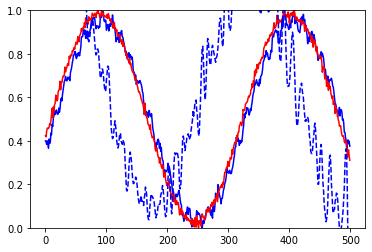

In [55]:
y,_ = generate_samples(n_sample=1,real=True)
plt.plot(y[0,:,0],'b')
y,_ = generate_samples(n_sample=1,real=False)
plt.plot(y[0,:,0],'r')
y = c_model.predict(y)
plt.plot(y[0,:,0],'b--')
plt.ylim(0,1)